In the previous notebook, Tim gave a fantastic example of working with a dataset and pipelining analysis given a dataset. One thing that was not mentioned is the ability for additional variables not explicitly in the original dataset to be calculated that can further enhance signal. 

In [19]:
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

#raw_trees=pd.read_csv("FinalOverObTableWAR.csv")

#Now that we have a data dictionary, we can get rid of many of the irrelevant columns. I selected this particular subset also using some forestry knowledge (doubtful of the various volume variables contribution to crown class)
fields = ['CLUSTER','ID',
'tree_obs_id','tree_spp',
'tree_dbh','tree_stems',
'tree_height','tree_crown_class',
'tree_stems_per','tree_ba',
'stand_id','OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id'
]

#Create a dataframe from just the subset of cols using same dataset from original notebook.
#reduced_data = pd.read_csv("FinalOverObTableWAR.csv", usecols = fields)


#Here is some code to merge both years and use that. 
year1 = pd.read_csv("FinalOverObTableWAR.csv",usecols = fields)
year2 = pd.read_csv("FinalOverObsTableWARyr2.csv",usecols = fields)

#add column for tracking
year1['Year'] = 'Year1'
year2['Year'] = 'Year2'

reduced_data = pd.concat([year1,year2]).dropna()
reduced_data.shape



/home/crgxcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(30828, 13)

We know that tree height is collected in 5 ft bins, which limits the resolution and categorical variables can be tricky. 
One way to convert it would be to add some random noise between (0,1) to each height bin that it falls in. 
This won't change the bin and it won't change the relation between trees.

In [21]:
reduced_data['tree_height_cont'] = reduced_data['tree_height'] + [random.random() for _ in range(0, len(reduced_data))]

reduced_data[['tree_height','tree_height_cont']].head(10)


,tree_height,tree_height_cont
0,65,65.273462
1,55,55.482517
2,50,50.921607
3,40,40.113939
4,65,65.042780
5,70,70.310267
6,65,65.847076
7,65,65.501405
8,65,65.826544
9,55,55.841029


Knowing what we know about crown class, we can think about how the height of a given tree is perhaps less important than it's height relative to it's peers. A 30' tall tree may be impressive in a seed tree cut, but less so in a mature stand. One way to codify this is to look at height percentiles and where a tree falls.

Height can be informative, but basal area is also very strongly of a individual's competitive status. We will also calculate the basal area percentile.

In [22]:
reduced_data['ht_percentile_stand'] = reduced_data.groupby('stand_id')['tree_height_cont'].rank(pct=True)
reduced_data['BA_percentile_stand'] = reduced_data.groupby('stand_id')['tree_ba'].rank(pct=True)

reduced_data['ht_percentile_plot'] = reduced_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_height_cont'].rank(pct=True)
reduced_data['BA_percentile_plot'] = reduced_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_ba'].rank(pct=True)

reduced_data['ht_percentile_ratio'] = reduced_data['ht_percentile_plot'] / reduced_data['ht_percentile_stand'] 
reduced_data['BA_percentile_ratio'] = reduced_data['BA_percentile_plot'] / reduced_data['BA_percentile_stand']




In [ ]:
#Still need to figure out BAL function...

#MWE
import pandas as pd
import numpy as np

df = pd.DataFrame({'Grp': [1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4], 
                   'Obs': [1,4,7,3,2,5,2,5,7,7,4,2,9,10,12,9,5,3,2,4,11,7,4,8,3],
                   'expected_output' : [28,17,0,21,26,12,26,12,38,38,45,49,22,12,0,0,9,18,21,14,0,19,26,11,30]})




Now that we have calculated everything, let's check if they actually are meaningful or if my hunch was incorrect. We can do this by running the subset variables and new calculated variables through a RandomForest and check the variable importance.

In [23]:
#random forest 


#we need to re-encode categorical variables
reduced_data['tree_spp2']=pd.factorize(reduced_data['tree_spp'])[0]
reduced_data['tree_obs_id2']=pd.factorize(reduced_data['tree_obs_id'])[0]

#predictors
features = ['tree_obs_id2','tree_spp2',
'tree_dbh','tree_stems',
'tree_height','tree_stems_per','tree_ba',
'tree_height_cont',
'ht_percentile_stand',
'BA_percentile_stand',
'ht_percentile_plot',
'BA_percentile_plot',
'ht_percentile_ratio',
'BA_percentile_ratio']

#response variable
train = ['tree_crown_class']

rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)

rnd_clf.fit(reduced_data[features], reduced_data["tree_crown_class"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

With the model fit, we have to do some more work to get a variable importance plot

tree_obs_id2 = 0.0648267717973607
tree_spp2 = 0.0335039636362346
tree_dbh = 0.04077262172753019
tree_stems = 1.0694478674148673e-05
tree_height = 0.03267238686843852
tree_stems_per = 0.029584906226793037
tree_ba = 0.03911478663503633
tree_height_cont = 0.11152407376309487
ht_percentile_stand = 0.1084900952654182
BA_percentile_stand = 0.08676522303218956
ht_percentile_plot = 0.12803437406344315
BA_percentile_plot = 0.13340671984620642
ht_percentile_ratio = 0.10078574762789745
BA_percentile_ratio = 0.09050763503168273


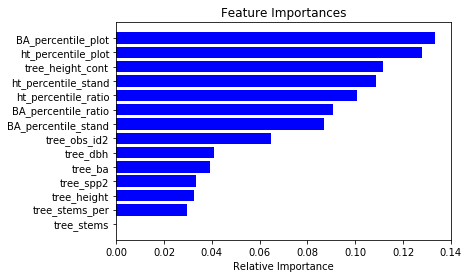

In [24]:
for name, importance in zip(reduced_data[features], rnd_clf.feature_importances_):
    print(name, "=", importance)

import numpy as np
feat = reduced_data[features]
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)



plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feat.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

So we can see that all of the calculated variables are at the top of the importance graph so we have been successful in creating meaningful features.

## Multinomial Regression

In [25]:
from sklearn.linear_model import LogisticRegression

X = reduced_data[features]
y = reduced_data['tree_crown_class']
lr = LogisticRegression(multi_class='multinomial',solver ='newton-cg')# newton-cg is a solver that can handle multinomial loss per documentation
lr.fit(X, y)
preds = lr.predict(X)


In [26]:
#print probability
lr.predict_proba(X).round(2)

array([[0.06, 0.94, 0.  , 0.  ],
       [0.59, 0.39, 0.02, 0.  ],
       [0.61, 0.37, 0.02, 0.  ],
       ...,
       [0.54, 0.43, 0.02, 0.  ],
       [0.12, 0.88, 0.  , 0.  ],
       [0.6 , 0.05, 0.31, 0.04]])

In [27]:
#get mean accuracy
lr.score(X, y).round(3)

0.659

In [11]:
y.unique()

array(['codominant', 'dominant', 'intermediate', 'suppressed'],
      dtype=object)

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

target_names = ['codominant', 'dominant', 'intermediate', 'suppressed']

print(classification_report(y, preds, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  codominant      0.666     0.758     0.709      8022
    dominant      0.709     0.651     0.679      4843
intermediate      0.535     0.461     0.496      2696
  suppressed      0.619     0.412     0.495      1014

    accuracy                          0.657     16575
   macro avg      0.632     0.571     0.595     16575
weighted avg      0.654     0.657     0.652     16575



In [34]:
#need to use statsmodel to get stat_summary info?

import statsmodels.formula.api as smf

#this formulatio has non-significant variables removed already, otherwise there are convergence issues
TMlogit = smf.mnlogit('tree_crown_class ~ tree_obs_id2 + tree_spp2 + tree_height + tree_ba + tree_height_cont + ht_percentile_plot + BA_percentile_plot', reduced_data)                   
                      
                    
TMlogit_fit = TMlogit.fit()

Optimization terminated successfully.
         Current function value: 0.764867
         Iterations 9


In [35]:
TMlogit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                30828
Model:                        MNLogit   Df Residuals:                    30804
Method:                           MLE   Df Model:                           21
Date:                Sat, 30 Nov 2019   Pseudo R-squ.:                  0.3555
Time:                        11:59:54   Log-Likelihood:                -23579.
converged:                       True   LL-Null:                       -36587.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
    y=tree_crown_class[dominant]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -5.5301      0.117    -47.407      0.000      -5.759      -5.302
tree_obs_id2                        -0.0211      0.004     -6.029      0.000      -0.028      -0.014
tree_spp2                           -0.0210      0.005     -3.852      0.000      -0.032      -0.010
tree_height                          0.6948      0.059     11.849      0.000       0.580       0.810
tree_ba                              0.8707      0.063     13.915      0.000       0.748       0.993
tree_height_cont                    -0.6632      0.059    -11.273      0.000      -0.779      -0.548
ht_percentile_plot                   2.7464      0.087     31.600      0.000       2.576       2.917
BA_percentile_plot                   2.4215      0.100     24.225      0.000       2.226       2.617
----------------------------------------------------------------------------------------------------
y=tree_crown_class[intermediate]       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.7105      0.113     32.754      0.000       3.488       3.932
tree_obs_id2                         0.0196      0.004      4.499      0.000       0.011       0.028
tree_spp2                            0.0520      0.005      9.538      0.000       0.041       0.063
tree_height                         -0.6110      0.072     -8.506      0.000      -0.752      -0.470
tree_ba                             -0.4240      0.130     -3.263      0.001      -0.679      -0.169
tree_height_cont                     0.5497      0.072      7.628      0.000       0.408       0.691
ht_percentile_plot                  -2.9707      0.124    -23.919      0.000      -3.214      -2.727
BA_percentile_plot                  -2.8612      0.141    -20.234      0.000      -3.138      -2.584
----------------------------------------------------------------------------------------------------
y=tree_crown_class[suppressed]       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          6.4957      0.169     38.533      0.000       6.165       6.826
tree_obs_id2                       0.0481      0.007      6.872      0.000       0.034       0.062
tree_spp2                          0.0578      0.008      6.895      0.000       0.041       0.074
tree_height                       -0.8239      0.116     -7.108      0.000      -1.051      -0.597
tree_ba                            1.2346      0.232      5.327      0.000       0.780       1.689
tree_height_cont                   0.6774      0.116      5.829      0.000       0.450       0.905
ht_percentile_plot                -6.5746      0.310    -21.215      0.000      -7.182      -5.967
BA_percentile_plot           